In [ ]:
!pip install transformers
!pip install torchvision
!pip install datasets
!pip install ftfy regex tqdm
!pip install -q git+https://github.com/openai/CLIP.git

!pip install Pillow==9.0.0 # Sometimes BLIP has compatibility issues with newer PIL versions, safer to specify
!pip install accelerate # Often needed for Hugging Face models


  Preparing metadata (setup.py) ... done


In [ ]:
import os
import torch
import clip
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel, BlipProcessor, BlipForConditionalGeneration
from sklearn.metrics import accuracy_score
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import json # For saving/loading captions
import numpy as np


In [ ]:
#mount to read/write other files in folder
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import kagglehub

# Download dataset
path = kagglehub.dataset_download("parthplc/facebook-hateful-meme-dataset")
print("Dataset path:", path)

# Load the training JSON
df = pd.read_json(path + '/data/train.jsonl', lines=True)
df.head()


Dataset path: /kaggle/input/facebook-hateful-meme-dataset


,id,img,label,text
0,42953,img/42953.png,0,its their character not their color that matters
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...
2,13894,img/13894.png,0,putting bows on your pet
3,37408,img/37408.png,0,i love everything and everybody! except for sq...
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h..."


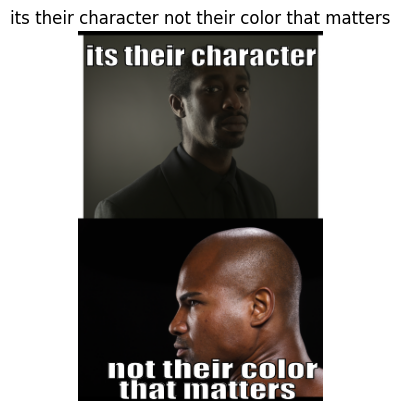

Label: Not Hateful


In [ ]:
sample = df.iloc[0]

image_path = os.path.join(path, "data", sample["img"])
img = Image.open(image_path)

plt.imshow(img)
plt.axis('off')
plt.title(sample["text"])
plt.show()

print("Label:", "Hateful" if sample["label"] == 1 else "Not Hateful")


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP
clip_model, preprocess = clip.load("ViT-B/32", device=device)
clip_model.eval()
for p in clip_model.parameters():
    p.requires_grad = False

# Choose text model
text_model_name = "xlm-roberta-base"


tokenizer = AutoTokenizer.from_pretrained(text_model_name)
text_model = AutoModel.from_pretrained(text_model_name).to(device)
text_model.eval() #sets model to inference mode (disables dropout).

# Load BLIP Processor and Model for Captioning
print("Loading BLIP captioning model...")
caption_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
caption_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)
caption_model.eval() # Set to evaluation mode as we are only using it for inference (generating captions)
for p in caption_model.parameters(): # Freeze BLIP captioning model parameters
    p.requires_grad = False
print("BLIP captioning model loaded.")


100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 171MiB/s]
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading BLIP captioning model...


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

BLIP captioning model loaded.


In [ ]:
cache_folder_in_drive = '/content/drive/MyDrive/Colab_HateMeme_Project_Cache'
os.makedirs(cache_folder_in_drive, exist_ok=True)
caption_cache_path = os.path.join(cache_folder_in_drive, "blip_captions_cache.json")

blip_captions_cache = {}
# Check if captions are already cached on disk
if os.path.exists(caption_cache_path):
    print("Loading BLIP captions from cache...")
    try:
        with open(caption_cache_path, 'r') as f:
            blip_captions_cache = json.load(f)
        print(f"Loaded {len(blip_captions_cache)} captions from cache.")
    except json.JSONDecodeError as e:
        print(f"Error reading caption cache: {e}. Re-generating captions.")
        # If the file is corrupted, proceed to regenerate
        os.remove(caption_cache_path) # Delete corrupted file
        blip_captions_cache = {} # Reset cache
else:
    print("BLIP captions cache not found. Generating and saving captions (this will take time on first run)...")

# If cache is empty (either not found or corrupted), generate captions
if not blip_captions_cache:
    # Use a combined DataFrame for all images we might need captions for
    # This ensures captions for both train and test images are generated if they are in the 'img' folder
    all_image_data = pd.concat([
        pd.read_json(os.path.join(path, 'data', 'train.jsonl'), lines=True),
        pd.read_json(os.path.join(path, 'data', 'dev.jsonl'), lines=True),
        pd.read_json(os.path.join(path, 'data', 'test.jsonl'), lines=True)
    ]).drop_duplicates(subset=['img']).reset_index(drop=True)

    for idx, row in all_image_data.iterrows():
        image_filename = row["img"]
        if image_filename in blip_captions_cache:
            continue # Skip if already in the current session's dict

        image_path_full = os.path.join(path, "data", image_filename)
        try:
            raw_image = Image.open(image_path_full).convert("RGB")
            with torch.no_grad():
                inputs_blip = caption_processor(images=raw_image, return_tensors="pt").to(device)
                generated_ids = caption_model.generate(**inputs_blip, max_new_tokens=50, do_sample=False, num_beams=1)
                generated_caption = caption_processor.decode(generated_ids[0], skip_special_tokens=True)
            blip_captions_cache[image_filename] = generated_caption
            if (idx + 1) % 100 == 0:
                print(f"  Generated {idx + 1}/{len(all_image_data)} captions...")
        except Exception as e:
            print(f"Error processing {image_filename}: {e}. Storing empty caption.")
            blip_captions_cache[image_filename] = "" # Store empty string for problematic images

    # Save the generated captions to disk
    with open(caption_cache_path, 'w') as f:
        json.dump(blip_captions_cache, f)
    print(f"Generated and saved {len(blip_captions_cache)} captions to {caption_cache_path}")
else:
    print("Using existing BLIP captions cache.")

Loading BLIP captions from cache...
Loaded 10000 captions from cache.
Using existing BLIP captions cache.


In [ ]:
# --- Prompt-based Data Processing ---
# Create a custom dataset to handle prompts and feature extraction on the fly

class HatefulMemeDataset(Dataset):
    def __init__(self, dataframe, image_dir, clip_preprocess, blip_captions_cache, tokenizer, device, has_labels=True):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.clip_preprocess = clip_preprocess
        self.blip_captions_cache = blip_captions_cache # This is the loaded dict
        self.tokenizer = tokenizer
        self.device = device
        self.has_labels = has_labels # Flag to indicate if 'label' column exists

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_filename = row["img"]

        image_path_full = os.path.join(self.image_dir, image_filename)
        raw_image = Image.open(image_path_full).convert("RGB")

        # Image preprocessing (for CLIP)
        image = self.clip_preprocess(raw_image)

        # Get caption from disk cache (NO BLIP GENERATION HERE)
        generated_caption = self.blip_captions_cache.get(image_filename, "")

        original_text = row["text"]

        # Prompt-based Text Input
        prompted_text = f"Analyze the following meme. Text: '{original_text}'. Image description: '{generated_caption}'. Is this meme hateful or not hateful? Answer:"

        # Handle label conditionally for test set
        if self.has_labels:
            label = row["label"]
        else:
            label = -1 # Placeholder for test set where labels are not provided

        return (image, prompted_text, label)

# --- Custom Collate Function for DataLoader ---
def collate_fn_contrastive(batch):
    images, texts, labels = zip(*batch)

    images_tensor = torch.stack(images)
    tokenized_texts = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=256)
    labels_tensor = torch.tensor(labels, dtype=torch.long)

    return images_tensor, tokenized_texts, labels_tensor

# --- Multimodal Fusion Module (AttentiveFusion) ---
class AttentiveFusion(nn.Module):
    def __init__(self, image_dim, text_dim, hidden_dim=512):
        super().__init__()
        self.image_transform = nn.Linear(image_dim, hidden_dim)
        self.text_transform = nn.Linear(text_dim, hidden_dim)
        self.attention_weights = nn.Linear(hidden_dim, 1)
        self.fusion_mlp = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1)
        )
        self.output_dim = hidden_dim

    def forward(self, image_feats, text_feats):
        img_h = F.relu(self.image_transform(image_feats))
        txt_h = F.relu(self.text_transform(text_feats))

        combined_h = img_h * txt_h
        attention_scores = torch.sigmoid(self.attention_weights(combined_h))
        attended_features = combined_h * attention_scores

        fused_features = self.fusion_mlp(torch.cat([img_h, txt_h], dim=1))

        return fused_features

# --- Supervised Contrastive Loss ---
class SupervisedContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.07):
        super().__init__()
        self.temperature = temperature

    def forward(self, feature_embeddings, labels):
        # Filter out placeholder labels (-1) if they exist (for test set processing)
        valid_indices = (labels != -1).nonzero(as_tuple=True)[0]
        if len(valid_indices) < 2 or len(labels[valid_indices].unique()) < 2:
            # Not enough samples or not enough unique classes for meaningful contrastive loss
            return torch.tensor(0.0).to(feature_embeddings.device)

        feature_embeddings = feature_embeddings[valid_indices]
        labels = labels[valid_indices]

        # Normalize features
        feature_embeddings = F.normalize(feature_embeddings, dim=1)

        # Compute cosine similarity between all pairs
        similarity_matrix = torch.matmul(feature_embeddings, feature_embeddings.T) / self.temperature

        # Create positive and negative masks
        labels = labels.contiguous().view(-1, 1)
        mask = torch.eq(labels, labels.T).float().to(feature_embeddings.device)
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(feature_embeddings.size(0)).view(-1, 1).to(feature_embeddings.device),
            0
        )
        mask = mask * logits_mask

        # For numerical stability: subtract max logit
        exp_logits = torch.exp(similarity_matrix) * logits_mask
        log_prob = similarity_matrix - torch.log(exp_logits.sum(1, keepdim=True))

        # Compute mean of log-likelihood over positive pairs
        # Avoid division by zero if mask.sum(1) is 0 (no positive pairs in a row)
        mean_log_prob_pos = (mask * log_prob).sum(1) / (mask.sum(1) + 1e-9) # Add small epsilon
        loss = -mean_log_prob_pos.mean()
        return loss

# --- 7. Combined Model Architecture ---
class HatefulMemeClassifier(nn.Module):
    def __init__(self, clip_model, text_model, fusion_module, num_classes=1):
        super().__init__()
        self.clip_model = clip_model
        self.text_model = text_model
        self.fusion_module = fusion_module
        self.classifier = nn.Linear(fusion_module.output_dim, num_classes)

    def forward(self, images, tokenized_texts):
        with torch.no_grad():
            image_feats = self.clip_model.encode_image(images)
            image_feats = image_feats.float()

        with torch.no_grad():
            text_output = self.text_model(**tokenized_texts)
            text_feats = text_output.last_hidden_state[:, 0, :]
            text_feats = text_feats.float()

        fused_feats = self.fusion_module(image_feats, text_feats)
        logits = self.classifier(fused_feats).squeeze(1)

        return fused_feats, logits


In [ ]:
# --- Setup for training ---
# Prepare datasets and DataLoaders
full_dataset = HatefulMemeDataset(df, os.path.join(path, "data"), preprocess, blip_captions_cache, tokenizer, device, has_labels=True)
train_indices, val_indices = train_test_split(range(len(full_dataset)), test_size=0.2, random_state=42)

train_dataset = torch.utils.data.Subset(full_dataset, train_indices)
val_dataset = torch.utils.data.Subset(full_dataset, val_indices)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn_contrastive)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn_contrastive)

print("Train size:", len(train_dataset))
print("Validation size:", len(val_dataset))


Train size: 6800
Validation size: 1700


In [ ]:
image_dim = clip_model.visual.output_dim
text_dim = text_model.config.hidden_size

fusion_module = AttentiveFusion(image_dim, text_dim, hidden_dim=512).to(device)
model = HatefulMemeClassifier(clip_model, text_model, fusion_module).to(device)

# Define optimizers and loss functions
optimizer = torch.optim.Adam(list(fusion_module.parameters()) + list(model.classifier.parameters()), lr=1e-5)
bce_loss_fn = torch.nn.BCEWithLogitsLoss()
contrastive_loss_fn = SupervisedContrastiveLoss(temperature=0.07)

# Loss weighting (can be tuned)
lambda_contrastive = 0.1


In [15]:
# --- Training Loop ---
num_epochs = 10
print("\nStarting Training...")
for epoch in range(num_epochs):
    model.train()
    total_bce_loss = 0.0
    total_contrastive_loss = 0.0
    total_loss = 0.0
    num_train_contrastive_batches = 0

    for batch_idx, (images, tokenized_texts, labels) in enumerate(train_loader):
        images = images.to(device)
        tokenized_texts = {k: v.to(device) for k, v in tokenized_texts.items()}
        labels = labels.float().to(device)

        fused_feats, logits = model(images, tokenized_texts)

        bce_loss = bce_loss_fn(logits, labels)

        # Only calculate contrastive loss if there are at least two unique classes in the batch
        if len(labels.unique()) > 1 and len(labels) > 1:
            contrastive_loss = contrastive_loss_fn(fused_feats, labels.long())
            num_train_contrastive_batches += 1
        else:
            contrastive_loss = torch.tensor(0.0).to(device)

        combined_loss = bce_loss + lambda_contrastive * contrastive_loss

        optimizer.zero_grad()
        combined_loss.backward()
        optimizer.step()

        total_bce_loss += bce_loss.item()
        total_contrastive_loss += contrastive_loss.item()
        total_loss += combined_loss.item()

        if (batch_idx + 1) % 100 == 0:
            print(f"  Batch {batch_idx+1}/{len(train_loader)} - BCE Loss: {bce_loss.item():.4f}, Contrastive Loss: {contrastive_loss.item():.4f}, Total Loss: {combined_loss.item():.4f}")

    avg_bce_loss = total_bce_loss / len(train_loader)
    # Average contrastive loss only over batches where it was actually computed
    avg_contrastive_loss = total_contrastive_loss / (num_train_contrastive_batches if num_train_contrastive_batches > 0 else 1)
    avg_total_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs} - Avg BCE Loss: {avg_bce_loss:.4f}, Avg Contrastive Loss: {avg_contrastive_loss:.4f}, Avg Total Loss: {avg_total_loss:.4f}")

    # --- Validation Loop ---
    model.eval()
    all_preds = []
    all_labels = []
    val_total_bce_loss = 0.0
    val_total_contrastive_loss = 0.0
    val_total_loss = 0.0
    num_val_contrastive_batches = 0

    with torch.no_grad():
        for images, tokenized_texts, labels in val_loader:
            images = images.to(device)
            tokenized_texts = {k: v.to(device) for k, v in tokenized_texts.items()}
            labels_float = labels.float().to(device)

            fused_feats, logits = model(images, tokenized_texts)

            bce_loss = bce_loss_fn(logits, labels_float)

            if len(labels.unique()) > 1 and len(labels) > 1:
                contrastive_loss = contrastive_loss_fn(fused_feats, labels.long())
                num_val_contrastive_batches += 1
            else:
                contrastive_loss = torch.tensor(0.0).to(device)

            combined_loss = bce_loss + lambda_contrastive * contrastive_loss

            val_total_bce_loss += bce_loss.item()
            val_total_contrastive_loss += contrastive_loss.item()
            val_total_loss += combined_loss.item()

            preds = (torch.sigmoid(logits) > 0.5).int().cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())

    val_avg_bce_loss = val_total_bce_loss / len(val_loader)
    val_avg_contrastive_loss = val_total_contrastive_loss / (num_val_contrastive_batches if num_val_contrastive_batches > 0 else 1)
    val_avg_total_loss = val_total_loss / len(val_loader)
    acc = accuracy_score(all_labels, all_preds)
    print(f"Validation Accuracy: {acc:.4f} - Avg Val BCE Loss: {val_avg_bce_loss:.4f}, Avg Val Contrastive Loss: {val_avg_contrastive_loss:.4f}, Avg Val Total Loss: {val_avg_total_loss:.4f}")


Starting Training...
  Batch 100/213 - BCE Loss: 0.5665, Contrastive Loss: 3.4995, Total Loss: 0.9165
  Batch 200/213 - BCE Loss: 0.6084, Contrastive Loss: 3.4736, Total Loss: 0.9557
Epoch 1/10 - Avg BCE Loss: 0.6109, Avg Contrastive Loss: 3.4582, Avg Total Loss: 0.9567
Validation Accuracy: 0.6682 - Avg Val BCE Loss: 0.6124, Avg Val Contrastive Loss: 3.4039, Avg Val Total Loss: 0.9528
  Batch 100/213 - BCE Loss: 0.5081, Contrastive Loss: 3.4024, Total Loss: 0.8484
  Batch 200/213 - BCE Loss: 0.5514, Contrastive Loss: 3.4725, Total Loss: 0.8987
Epoch 2/10 - Avg BCE Loss: 0.6029, Avg Contrastive Loss: 3.4582, Avg Total Loss: 0.9488
Validation Accuracy: 0.6824 - Avg Val BCE Loss: 0.6066, Avg Val Contrastive Loss: 3.4039, Avg Val Total Loss: 0.9470
  Batch 100/213 - BCE Loss: 0.4616, Contrastive Loss: 3.3928, Total Loss: 0.8009
  Batch 200/213 - BCE Loss: 0.5190, Contrastive Loss: 3.4429, Total Loss: 0.8633
Epoch 3/10 - Avg BCE Loss: 0.5954, Avg Contrastive Loss: 3.4556, Avg Total Loss: 0

In [ ]:
# "HateMemeDetect_PromptedFusion_Contrastive"

In [16]:
# --- Test Prediction ---
print("\nStarting Test Prediction...")
# Load the test JSON
test_df = pd.read_json(os.path.join(path, 'data', 'test.jsonl'), lines=True)
print(f"Loaded test data with {len(test_df)} samples.")

# Instantiate test dataset with has_labels=False
test_dataset = HatefulMemeDataset(test_df, os.path.join(path, "data"), preprocess, blip_captions_cache, tokenizer, device, has_labels=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn_contrastive)

model.eval()

all_ids = [] # To store meme IDs for submission
all_preds = []
all_probs = []

with torch.no_grad():
    for i, (images, tokenized_texts, labels) in enumerate(test_loader):
        # Get IDs from the original test_df for this batch
        # Note: This assumes test_df's order matches test_loader's order (which it does with shuffle=False)
        batch_ids = test_df.iloc[i * test_loader.batch_size : (i + 1) * test_loader.batch_size]["id"].tolist()

        images = images.to(device)
        tokenized_texts = {k: v.to(device) for k, v in tokenized_texts.items()}

        fused_feats, logits = model(images, tokenized_texts)
        preds = (torch.sigmoid(logits) > 0.5).int().cpu().numpy()
        batch_probs = torch.sigmoid(logits).cpu().numpy()

        all_ids.extend(batch_ids)
        all_preds.extend(preds)
        all_probs.extend(batch_probs)

print("Test predictions complete.")
print(f"Generated predictions for {len(all_preds)} samples.")



Starting Test Prediction...
Loaded test data with 1000 samples.
Test predictions complete.
Generated predictions for 1000 samples.


## Save Outputs

In [17]:
output_dir = "outputs"
os.makedirs(output_dir, exist_ok=True)

if len(all_labels) > 0:
    np.save(os.path.join(output_dir, "y_true_xlmr_sota.npy"), np.array(all_labels))
    np.save(os.path.join(output_dir, "y_preds_xlmr_sota.npy"), np.array(all_preds))
    np.save(os.path.join(output_dir, "y_probs_xlmr_sota.npy"), np.array(all_probs))
else:
    np.save(os.path.join(output_dir, "y_preds_xlmr_sota.npy"), np.array(all_preds))
    np.save(os.path.join(output_dir, "y_probs_xlmr_sota.npy"), np.array(all_probs))

print(f"Outputs saved to {output_dir}")


Outputs saved to outputs
